In [ ]:
# Figure 7A

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Generators.CNN import CNN
from itertools import product

def hamming_distance(seq1, seq2):
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def generate_hybrids(A, B, up, down):

    differing_indices = [i for i in range(len(A)) if A[i] != B[i]]
    hybrids = []
    dist_to_As = []
    dist_to_Bs = []

    for choice in product([0, 1], repeat=len(differing_indices)):
        hybrid_chars = list(A)
        for idx, bit in zip(differing_indices, choice):
            hybrid_chars[idx] = B[idx] if bit == 1 else A[idx]

        hybrid = ''.join(hybrid_chars)
        dist_to_A = sum(1 for i in differing_indices if hybrid_chars[i] != A[i])
        dist_to_B = sum(1 for i in differing_indices if hybrid_chars[i] != B[i])

        hybrids.append(up + hybrid + down)
        dist_to_As.append(dist_to_A)
        dist_to_Bs.append(dist_to_B)

    return hybrids, dist_to_As, dist_to_Bs

kwargs = {
    'cnn_model_path': 'Models/CNN_6_1_2.keras',
    'masked_sequence': 'AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTGGGCGGGAAGACAACTAGGGG',
    'early_stopping_patience': 100,
}
target_expressions = [0, 0.25, 0.5, 0.75, 1]

iterations = 5

cnn = CNN(kwargs['cnn_model_path'])

# Load and preprocess the data
results_df = pd.read_csv('Data/optimizer_evaluation_results.csv')
results_df = results_df[results_df['optimizer'] == 'Genetic Algorithm']
results_df = results_df[results_df['target_expression'] == 1]

results_df = results_df.sort_values(by='error')
GA_1 = results_df['sequence'].iloc[0][20:50]
GA_2 = results_df['sequence'].iloc[1][20:50]

differences_2 = [True if GA_1[i] != GA_2[i] else False for i in range(len(GA_1))]

up = 'AATACTAGAGGTCTTCCGAC'
down = 'GTGTGGGCGGGAAGACAACTAGGGG'

hybrids, dist_to_1, dist_to_2 = generate_hybrids(GA_1, GA_2, up, down)

predictions = cnn.predict(cnn.preprocess(hybrids))

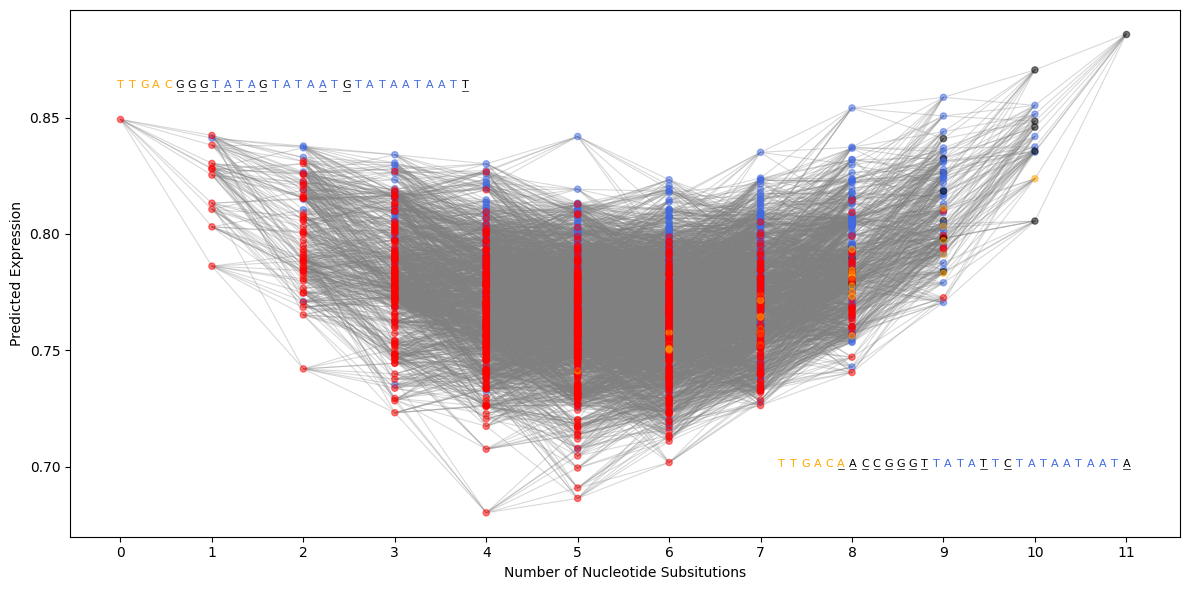

In [ ]:
def matched_nucleotides(s, target, min_shared=5):
    t_len = len(target)
    nucleotide_map = [False] * len(s)

    for i in range(len(s) - t_len + 1):
        window = s[i:i + t_len]
        match_positions = [j for j in range(t_len) if window[j] == target[j]]
        if len(match_positions) >= min_shared:
            for j in match_positions:
                nucleotide_map[i + j] = True

    return nucleotide_map

match_color = 'black'
diff_color = 'black'
h35_color = 'orange'
h10_color = 'royalblue'
h35 = 'TTGACA'
h10 = 'TATAAT'
fontsize = 8
char_width = 0.13
underline_offset = 0.001
underline_length = 0.07

h35_match_GA1 = matched_nucleotides(GA_1, h35)
h10_match_GA1 = matched_nucleotides(GA_1, h10)
h35_match_GA2 = matched_nucleotides(GA_2, h35)
h10_match_GA2 = matched_nucleotides(GA_2, h10)

grouped = {}
for dist, pred, seq in zip(dist_to_2, predictions, hybrids):
    grouped.setdefault(dist, []).append((seq, pred))

plt.figure(figsize=(12, 6))

sorted_dists = sorted(grouped.keys())
for i in range(len(sorted_dists) - 1):
    d1 = sorted_dists[i]
    d2 = sorted_dists[i + 1]
    group1 = grouped[d1]
    group2 = grouped[d2]

    for seq1, pred1 in group1:
        for seq2, pred2 in group2:
            if hamming_distance(seq1, seq2) == 1:
                plt.plot([d1, d2], [pred1, pred2], color='grey', alpha=0.3, linewidth=0.8)

def get_mismatch_category(seq, ref, h10_mask, h35_mask):
    h10_mismatch = any(ref[i] != seq[i] and h10_mask[i] for i in range(len(ref)))
    h35_mismatch = any(ref[i] != seq[i] and h35_mask[i] for i in range(len(ref)))
    
    if h10_mismatch and h35_mismatch:
        return 'red'
    elif h10_mismatch:
        return 'royalblue'
    elif h35_mismatch:
        return 'orange'
    else:
        return 'black'

for dist, items in grouped.items():
    items.sort(key=lambda x: x[0])
    sequences, preds = zip(*items)
    x_vals = [dist] * len(preds)

    # Determine color for each point
    point_colors = []
    for seq in sequences:
        color = get_mismatch_category(seq[20:50], GA_1, h10_match_GA1, h35_match_GA1)
        point_colors.append(color)

    plt.scatter(x_vals, preds, color=point_colors, alpha=0.5, s=20, zorder=3)

x0 = 0
y0 = 0.8625
for i, (c1, c2) in enumerate(zip(GA_1, GA_2)):
    if h35_match_GA2[i]:
        color = h35_color
    elif h10_match_GA2[i]:
        color = h10_color
    elif c1 == c2:
        color = match_color
    else:
        color = diff_color
    x_char = x0 + i * char_width
    plt.text(x_char, y0, c2, fontsize=fontsize, ha='center', color=color)
    if c1 != c2:
        plt.plot(
            [x_char - underline_length/2, x_char + underline_length/2],
            [y0 - underline_offset] * 2,
            color='black',
            linewidth=0.5
        )

x1 = 11
y1 = 0.7
for i, (c1, c2) in enumerate(zip(GA_1, GA_2)):
    if h35_match_GA1[i]:
        color = h35_color
    elif h10_match_GA1[i]:
        color = h10_color
    elif c1 == c2:
        color = match_color
    else:
        color = diff_color
    x_char = x1 - (len(GA_2) - i - 1) * char_width
    plt.text(x_char, y1, c1, fontsize=fontsize, ha='center', color=color)
    if c1 != c2:
        plt.plot(
            [x_char - underline_length/2, x_char + underline_length/2],
            [y1 - underline_offset] * 2,
            color='black',
            linewidth=0.5
        )

plt.xticks(range(min(sorted_dists), max(sorted_dists) + 1, 1))
plt.xlabel(f'Number of Nucleotide Subsitutions')
plt.ylabel('Predicted Expression')
plt.tight_layout()
plt.show()

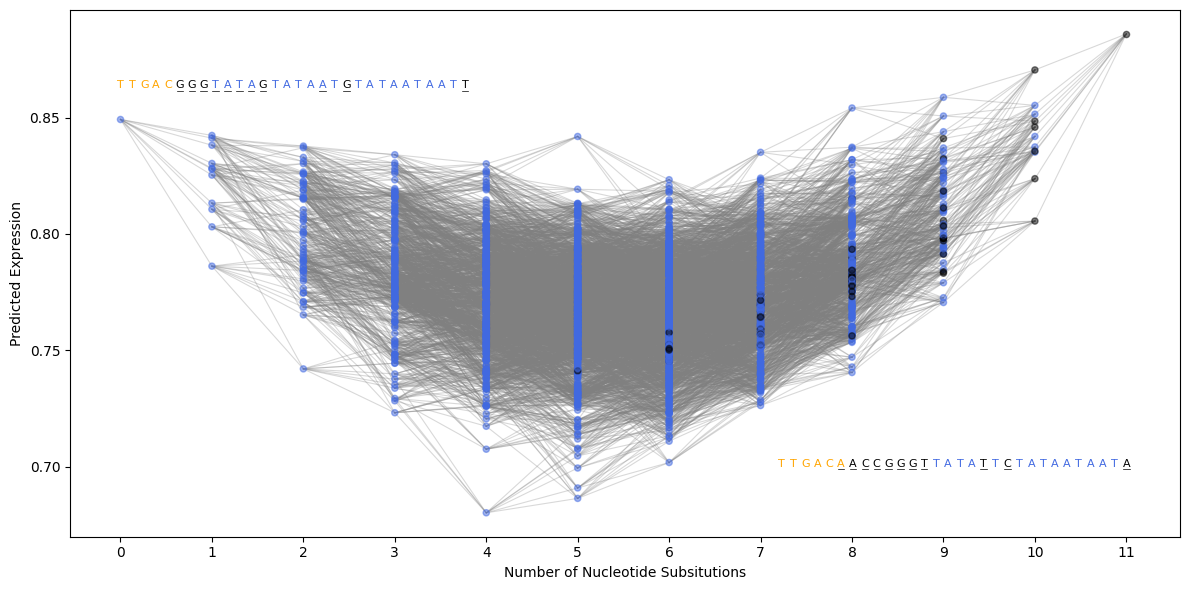

In [53]:
def matched_nucleotides(s, target, min_shared=5):
    t_len = len(target)
    nucleotide_map = [False] * len(s)

    for i in range(len(s) - t_len + 1):
        window = s[i:i + t_len]
        match_positions = [j for j in range(t_len) if window[j] == target[j]]
        if len(match_positions) >= min_shared:
            for j in match_positions:
                nucleotide_map[i + j] = True

    return nucleotide_map

match_color = 'black'
diff_color = 'black'
h35_color = 'orange'
h10_color = 'royalblue'
h35 = 'TTGACA'
h10 = 'TATAAT'
fontsize = 8
char_width = 0.13
underline_offset = 0.001
underline_length = 0.07

h35_match_GA1 = matched_nucleotides(GA_1, h35)
h10_match_GA1 = matched_nucleotides(GA_1, h10)
h35_match_GA2 = matched_nucleotides(GA_2, h35)
h10_match_GA2 = matched_nucleotides(GA_2, h10)

grouped = {}
for dist, pred, seq in zip(dist_to_2, predictions, hybrids):
    grouped.setdefault(dist, []).append((seq, pred))

plt.figure(figsize=(12, 6))

sorted_dists = sorted(grouped.keys())
for i in range(len(sorted_dists) - 1):
    d1 = sorted_dists[i]
    d2 = sorted_dists[i + 1]
    group1 = grouped[d1]
    group2 = grouped[d2]

    for seq1, pred1 in group1:
        for seq2, pred2 in group2:
            if hamming_distance(seq1, seq2) == 1:
                plt.plot([d1, d2], [pred1, pred2], color='grey', alpha=0.3, linewidth=0.8)

def get_mismatch_category(seq, ref, h10_mask, h35_mask):
    h10_mismatch = any(ref[i] != seq[i] and h10_mask[i] for i in range(len(ref)))
    h35_mismatch = any(ref[i] != seq[i] and h35_mask[i] for i in range(len(ref)))
    
    if h10_mismatch and h35_mismatch:
        return 'red'
    elif h10_mismatch:
        return 'royalblue'
    elif h35_mismatch:
        return 'orange'
    else:
        return 'black'

for dist, items in grouped.items():
    items.sort(key=lambda x: x[0])
    sequences, preds = zip(*items)
    x_vals = [dist] * len(preds)

    # Determine color for each point
    point_colors = []
    for seq in sequences:
        color = get_mismatch_category(seq[20:50], GA_1, h10_match_GA2, h35_match_GA2)
        point_colors.append(color)

    plt.scatter(x_vals, preds, color=point_colors, alpha=0.5, s=20, zorder=3)

x0 = 0
y0 = 0.8625
for i, (c1, c2) in enumerate(zip(GA_1, GA_2)):
    if h35_match_GA2[i]:
        color = h35_color
    elif h10_match_GA2[i]:
        color = h10_color
    elif c1 == c2:
        color = match_color
    else:
        color = diff_color
    x_char = x0 + i * char_width
    plt.text(x_char, y0, c2, fontsize=fontsize, ha='center', color=color)
    if c1 != c2:
        plt.plot(
            [x_char - underline_length/2, x_char + underline_length/2],
            [y0 - underline_offset] * 2,
            color='black',
            linewidth=0.5
        )

x1 = 11
y1 = 0.7
for i, (c1, c2) in enumerate(zip(GA_1, GA_2)):
    if h35_match_GA1[i]:
        color = h35_color
    elif h10_match_GA1[i]:
        color = h10_color
    elif c1 == c2:
        color = match_color
    else:
        color = diff_color
    x_char = x1 - (len(GA_2) - i - 1) * char_width
    plt.text(x_char, y1, c1, fontsize=fontsize, ha='center', color=color)
    if c1 != c2:
        plt.plot(
            [x_char - underline_length/2, x_char + underline_length/2],
            [y1 - underline_offset] * 2,
            color='black',
            linewidth=0.5
        )

plt.xticks(range(min(sorted_dists), max(sorted_dists) + 1, 1))
plt.xlabel(f'Number of Nucleotide Subsitutions')
plt.ylabel('Predicted Expression')
plt.tight_layout()
plt.show()

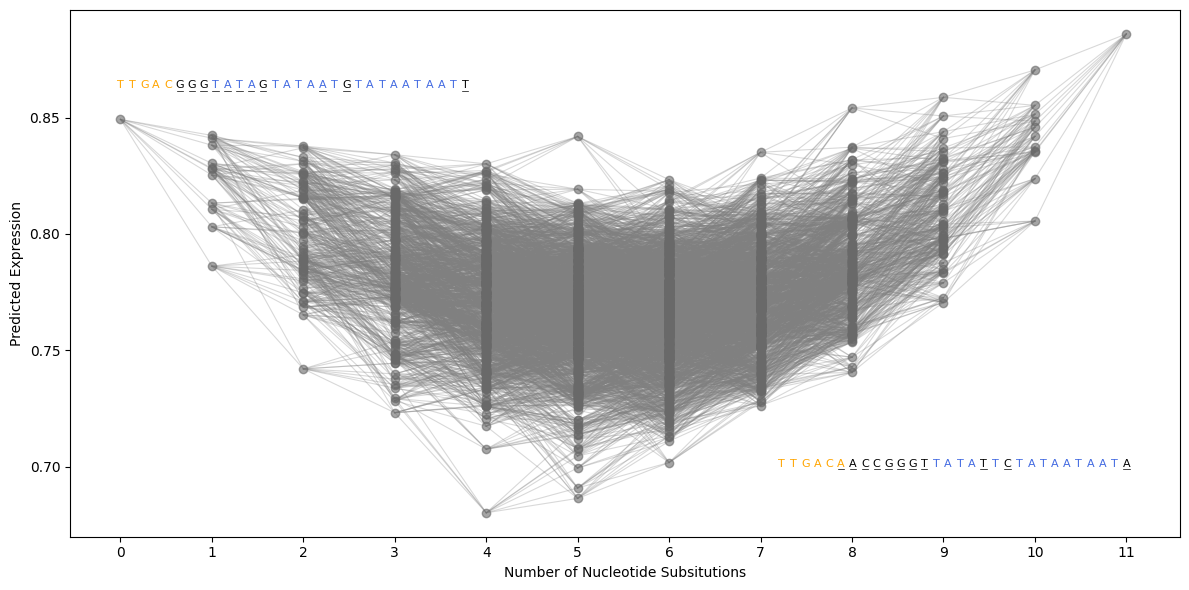

In [ ]:
def matched_nucleotides(s, target, min_shared=5):
    t_len = len(target)
    nucleotide_map = [False] * len(s)

    for i in range(len(s) - t_len + 1):
        window = s[i:i + t_len]
        match_positions = [j for j in range(t_len) if window[j] == target[j]]
        if len(match_positions) >= min_shared:
            for j in match_positions:
                nucleotide_map[i + j] = True

    return nucleotide_map

grouped = {}
for dist, pred, seq in zip(dist_to_2, predictions, hybrids):
    grouped.setdefault(dist, []).append((seq, pred))

plt.figure(figsize=(12, 6))

sorted_dists = sorted(grouped.keys())
for i in range(len(sorted_dists) - 1):
    d1 = sorted_dists[i]
    d2 = sorted_dists[i + 1]
    group1 = grouped[d1]
    group2 = grouped[d2]

    for seq1, pred1 in group1:
        for seq2, pred2 in group2:
            if hamming_distance(seq1, seq2) == 1:
                plt.plot([d1, d2], [pred1, pred2], color='grey', alpha=0.3, linewidth=0.8)

for dist, items in grouped.items():
    items.sort(key=lambda x: x[0])
    sequences, preds = zip(*items)
    x_vals = [dist] * len(preds)
    plt.scatter(x_vals, preds, label=f'Distance {dist}', color='dimgray', alpha=0.6, zorder=3,)

match_color = 'black'
diff_color = 'black'
h35_color = 'orange'
h10_color = 'royalblue'
h35 = 'TTGACA'
h10 = 'TATAAT'
fontsize = 8
char_width = 0.13
underline_offset = 0.001
underline_length = 0.07

h35_match_GA1 = matched_nucleotides(GA_1, h35)
h10_match_GA1 = matched_nucleotides(GA_1, h10)
h35_match_GA2 = matched_nucleotides(GA_2, h35)
h10_match_GA2 = matched_nucleotides(GA_2, h10)

x0 = 0
y0 = 0.8625
for i, (c1, c2) in enumerate(zip(GA_1, GA_2)):
    if h35_match_GA2[i]:
        color = h35_color
    elif h10_match_GA2[i]:
        color = h10_color
    elif c1 == c2:
        color = match_color
    else:
        color = diff_color
    x_char = x0 + i * char_width
    plt.text(x_char, y0, c2, fontsize=fontsize, ha='center', color=color)
    if c1 != c2:
        plt.plot(
            [x_char - underline_length/2, x_char + underline_length/2],
            [y0 - underline_offset] * 2,
            color='black',
            linewidth=0.5
        )

x1 = 11
y1 = 0.7
for i, (c1, c2) in enumerate(zip(GA_1, GA_2)):
    if h35_match_GA1[i]:
        color = h35_color
    elif h10_match_GA1[i]:
        color = h10_color
    elif c1 == c2:
        color = match_color
    else:
        color = diff_color
    x_char = x1 - (len(GA_2) - i - 1) * char_width
    plt.text(x_char, y1, c1, fontsize=fontsize, ha='center', color=color)
    if c1 != c2:
        plt.plot(
            [x_char - underline_length/2, x_char + underline_length/2],
            [y1 - underline_offset] * 2,
            color='black',
            linewidth=0.5
        )

plt.xticks(range(min(sorted_dists), max(sorted_dists) + 1, 1))
plt.xlabel(f'Number of Nucleotide Subsitutions')
plt.ylabel('Predicted Expression')
plt.tight_layout()
plt.show()